<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/tc_practice/blob/main/06_VAE.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jjerry-k/tc_practice/blob/main/06_VAE.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Variational Auto Encoder

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0].
This notebook use [cuda:0].


# Set hyper-parameter

In [2]:
EPOCHS = 20
LATENT_SIZE = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001

# Prepare dataset

In [3]:
transform = transforms.Compose([
                transforms.ToTensor()
                ])
# MNIST dataset
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print("Preparing dataset done!")

Preparing dataset done!


# Defining Model

In [4]:
# our model
class Model(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=500, latent_dim=20, init_weight="he", init_bias="zero"):
        super(Model, self).__init__()

        self.init_weight = init_weight
        self.init_bias = init_bias
        
        self.en_fc1 = nn.Sequential(*[nn.Linear(input_dim, hidden_dims), nn.ReLU(True)])
        self.en_mu = nn.Linear(hidden_dims, latent_dim)
        self.en_logvar = nn.Linear(hidden_dims, latent_dim)
        self.de_fc1 = nn.Sequential(*[nn.Linear(latent_dim, hidden_dims), nn.ReLU(True)])
        self.de_fc2 = nn.Sequential(*[nn.Linear(hidden_dims, input_dim), nn.Sigmoid()])

        self.init_params()
        
    def init_params(self):
        
        init_weight_method = {
        "he": nn.init.kaiming_normal_, 
        "xavier": nn.init.xavier_normal_
        }
        assert self.init_weight in init_weight_method.keys(), f'Select the weight initialization method in {list(init_weight_method.keys())}'
        
        init_bias_method = {
            "zero": nn.init.zeros_, 
            "uniform": nn.init.uniform_
        }
        assert self.init_bias in init_bias_method.keys(), f'Select the bias initialization method in {list(init_bias_method.keys())}'

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weight_method[self.init_weight](m.weight)
                init_bias_method[self.init_bias](m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def encode(self, x):
        out = self.en_fc1(x)
        return self.en_mu(out), self.en_logvar(out)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decoder(self, z):
        out = self.de_fc1(z)
        return self.de_fc2(out)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

model = Model().to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def criterion(x_recon, x, mu, logvar):
    bce_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')

    kl_loss = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return bce_loss + kl_loss, bce_loss, kl_loss

# Calculate Parameters

In [5]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f"Number of Total Parameters: {total_params:,d}")

Number of Total Parameters: 815,824


# Define help function

In [6]:
def plot_generator(model, num = 64, latent_size = 20):
    z = torch.randn(num, latent_size).to(device)
    
    model.eval()
    test_g = model.decoder(z)
    model.train()
    
    plt.figure(figsize=(8, 6))
    for i in range(num):
        plt.subplot(8, 8, i+1)
        plt.imshow(test_g[i].view(28, 28).data.cpu().numpy(), cmap=plt.cm.gray)
        plt.axis('off')
    plt.show()

# Train model 

Start training !
Epoch: 1, Loss: 159.51364135742188, Recon Loss: 143.4950408935547, KL Loss: 16.01860809326172
Epoch: 2, Loss: 59.83669662475586, Recon Loss: 48.48399353027344, KL Loss: 11.352705001831055
Epoch: 3, Loss: 37.782108306884766, Recon Loss: 29.71713638305664, KL Loss: 8.064971923828125
Epoch: 4, Loss: 27.656036376953125, Recon Loss: 21.48719024658203, KL Loss: 6.168846607208252
Epoch: 5, Loss: 21.80739402770996, Recon Loss: 16.827299118041992, KL Loss: 4.980093002319336


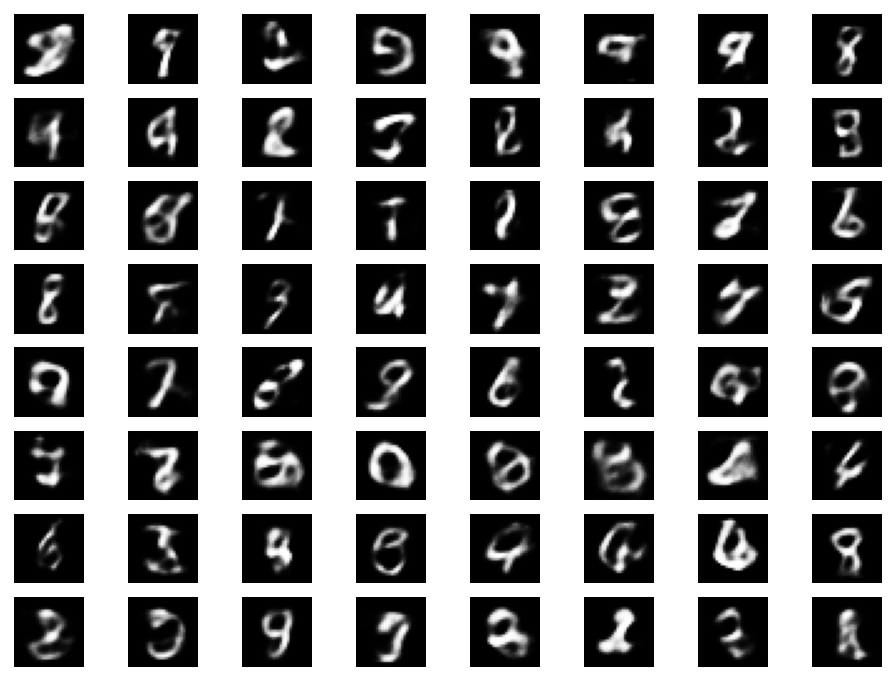

Epoch: 6, Loss: 17.983013153076172, Recon Loss: 13.806283950805664, KL Loss: 4.176729202270508
Epoch: 7, Loss: 15.296454429626465, Recon Loss: 11.702957153320312, KL Loss: 3.5934975147247314
Epoch: 8, Loss: 13.307893753051758, Recon Loss: 10.153955459594727, KL Loss: 3.153938055038452
Epoch: 9, Loss: 11.771299362182617, Recon Loss: 8.96186637878418, KL Loss: 2.8094325065612793
Epoch: 10, Loss: 10.558900833129883, Recon Loss: 8.026632308959961, KL Loss: 2.5322682857513428


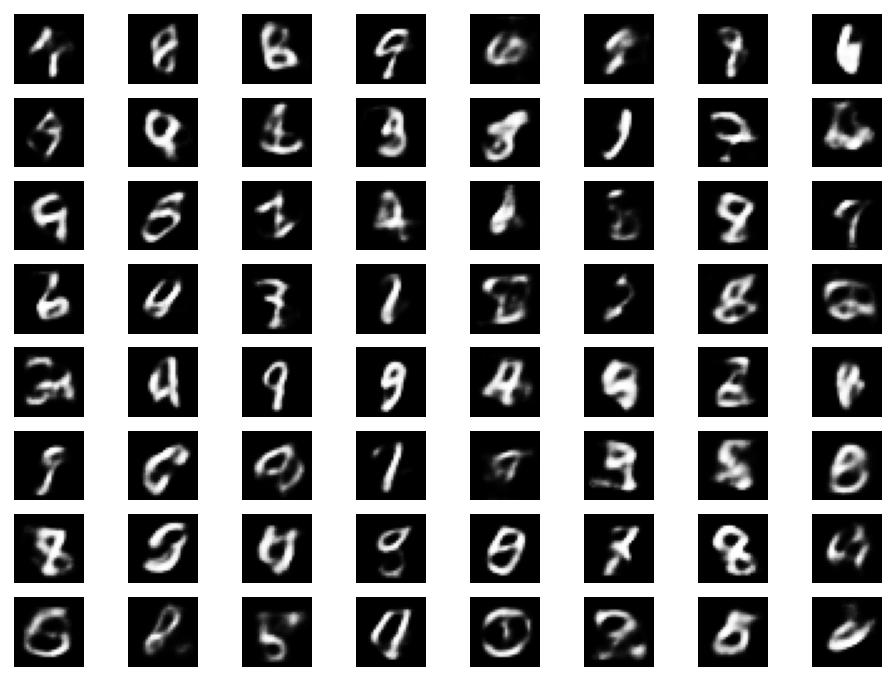

Epoch: 11, Loss: 9.561924934387207, Recon Loss: 7.256734371185303, KL Loss: 2.3051908016204834
Epoch: 12, Loss: 8.741433143615723, Recon Loss: 6.626891613006592, KL Loss: 2.1145408153533936
Epoch: 13, Loss: 8.051636695861816, Recon Loss: 6.094840049743652, KL Loss: 1.9567959308624268
Epoch: 14, Loss: 7.454310894012451, Recon Loss: 5.638486862182617, KL Loss: 1.8158241510391235
Epoch: 15, Loss: 6.945159435272217, Recon Loss: 5.248159408569336, KL Loss: 1.6970000267028809


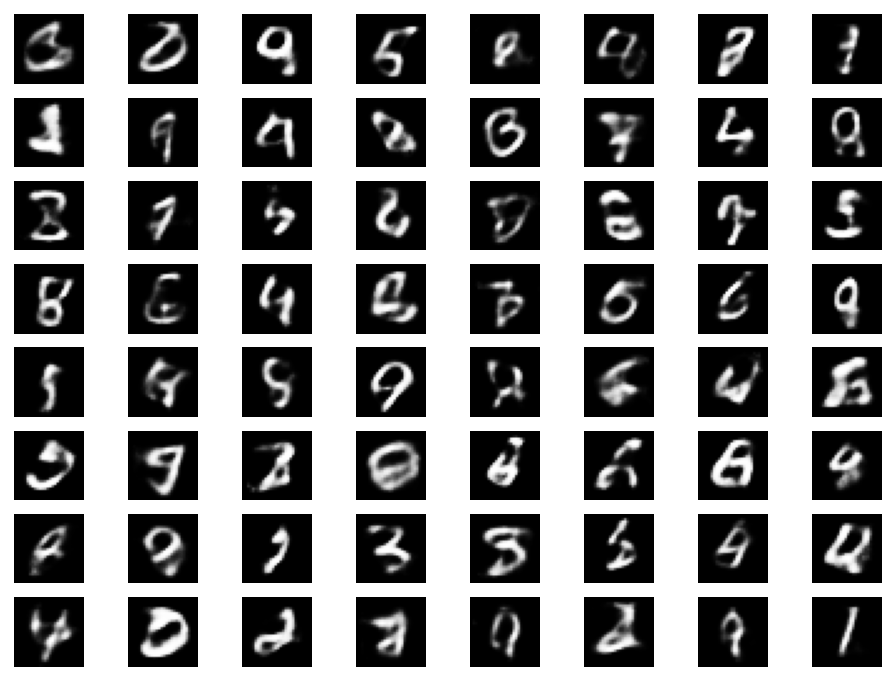

Epoch: 16, Loss: 6.500077247619629, Recon Loss: 4.908594131469727, KL Loss: 1.5914825201034546
Epoch: 17, Loss: 6.1040544509887695, Recon Loss: 4.6063690185546875, KL Loss: 1.4976859092712402
Epoch: 18, Loss: 5.753900527954102, Recon Loss: 4.340013027191162, KL Loss: 1.413887619972229
Epoch: 19, Loss: 5.445496559143066, Recon Loss: 4.104171276092529, KL Loss: 1.3413251638412476
Epoch: 20, Loss: 5.164662837982178, Recon Loss: 3.891287088394165, KL Loss: 1.2733758687973022


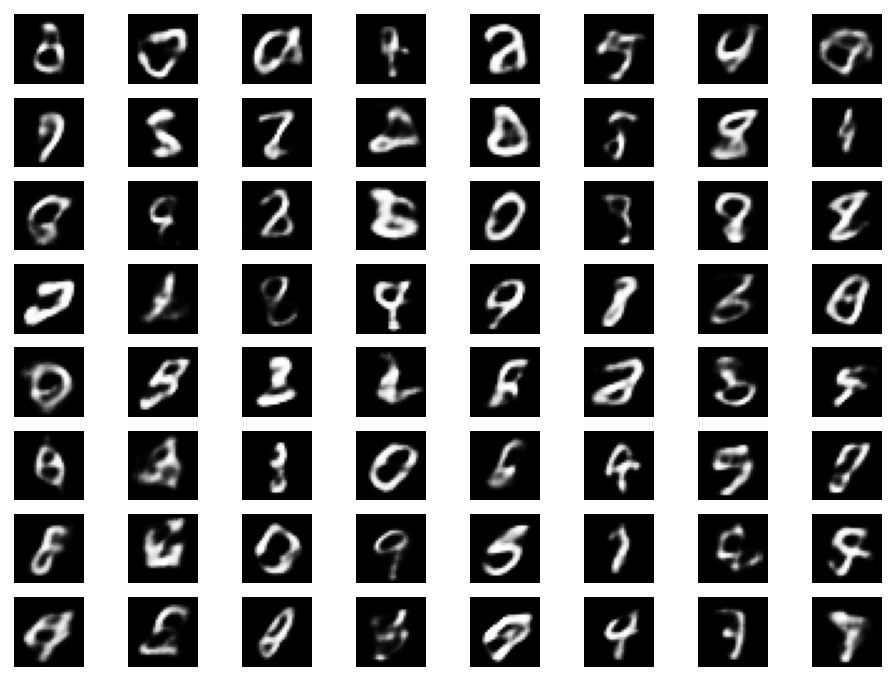

Training Done !


In [7]:
# Training Phase
print_every = 1
plot_every = 5
print("Start training !")
total = 0
# Training loop
for epoch in range(EPOCHS):
    bce_sum = 0
    kl_sum = 0
    for batch_img, _ in train_iter:

        X = batch_img.view(batch_img.size(0), -1).to(device)
        
        x_recon, mu, logvar = model(X)
        
        # Training Discriminator
        loss, bce_loss, kl_loss = criterion(x_recon, X, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += X.size(0)
        bce_sum += bce_loss
        kl_sum += kl_loss
        
    if (((epoch+1)%print_every)==0) or ((epoch+1)==(EPOCHS-1)):
            print(f"Epoch: {epoch+1}, Loss: {(bce_sum+kl_sum)/total}, Recon Loss: {bce_sum/total}, KL Loss: {kl_sum/total}")
    if (((epoch+1)%plot_every)==0) or ((epoch+1)==(EPOCHS)):
        plot_generator(model)
print("Training Done !")